In [1]:
import numpy as np
import matplotlib.pyplot as plt
import muram as mio
from astropy.io import fits
import pyflct
import matplotlib.patches as patches
from copy import copy

In [2]:
from matplotlib import font_manager
import matplotlib as mpl
font_path = '/home/mistflow/.fonts/cmunrm.ttf'  # Your font path goes here
#font_path = '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams["font.size"] = 14
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rc('axes', unicode_minus=False)

In [3]:
from scipy.stats import pearsonr

In [4]:
from scipy.ndimage import gaussian_filter

In [5]:
# Define function for temporal averaging
def temporal_avg(data_in, start, end):
    tmp_avg = np.mean(data_in[start:end+1], axis = 0)
    return tmp_avg

In [6]:
def mean_v_from_file(file):
    v_x = fits.open(file)[0].data.transpose(0, 2, 1)
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

def mean_vy_from_file(file):
    v_x = fits.open(file)[1].data.transpose(0, 2, 1)
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

In [7]:
Vx_600I = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Inte_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_600I = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Inte_tracked.fits")[1].data.transpose(0, 2, 1)

In [8]:
Vx_300I = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Inte_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_300I = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Inte_tracked.fits")[1].data.transpose(0, 2, 1)

In [9]:
Vx_600I_mean = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Inte_tracked.fits")
Vy_600I_mean = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Inte_tracked.fits")

In [10]:
Vx_300I_mean = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Inte_tracked.fits")
Vy_300I_mean = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Inte_tracked.fits")

In [11]:
Vx = fits.open("Velocities_TAU_1_0.fits")[1].data # Vy from Velocities.fits as originally thought
Vy = fits.open("Velocities_TAU_1_0.fits")[0].data # Vx from Velocities.fits as originally thought
Vx = Vx[::3]
Vy = Vy[::3]

In [12]:
Vx_mean_sim90 = temporal_avg(Vx, 0, 90)
Vx_mean_sim90 = Vx_mean_sim90/1E5

Vy_mean_sim90 = temporal_avg(Vy, 0, 90)
Vy_mean_sim90 = Vy_mean_sim90/1E5

In [13]:
Vx_filtered22 = gaussian_filter(Vx_mean_sim90, 22.5, mode = "wrap")
Vy_filtered22 = gaussian_filter(Vy_mean_sim90, 22.5, mode = "wrap")

In [14]:
Vx_filtered11 = gaussian_filter(Vx_mean_sim90, 11.25, mode = "wrap")
Vy_filtered11 = gaussian_filter(Vy_mean_sim90, 11.25, mode = "wrap")

In [15]:
from scipy.stats import linregress

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap
#import mpl_scatter_density
from scipy.stats import gaussian_kde
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

import datashader.transfer_functions as tf
import datashader as ds
from datashader.mpl_ext import dsshow
import pandas as pd
import holoviews as hv
from holoviews.operation.datashader import dynspread
from holoviews.operation.datashader import datashade
import hvplot

In [17]:
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    plt.scatter( x, y, c=z, cmap = "viridis", **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

CPU times: user 6.44 s, sys: 952 ms, total: 7.39 s
Wall time: 7.37 s


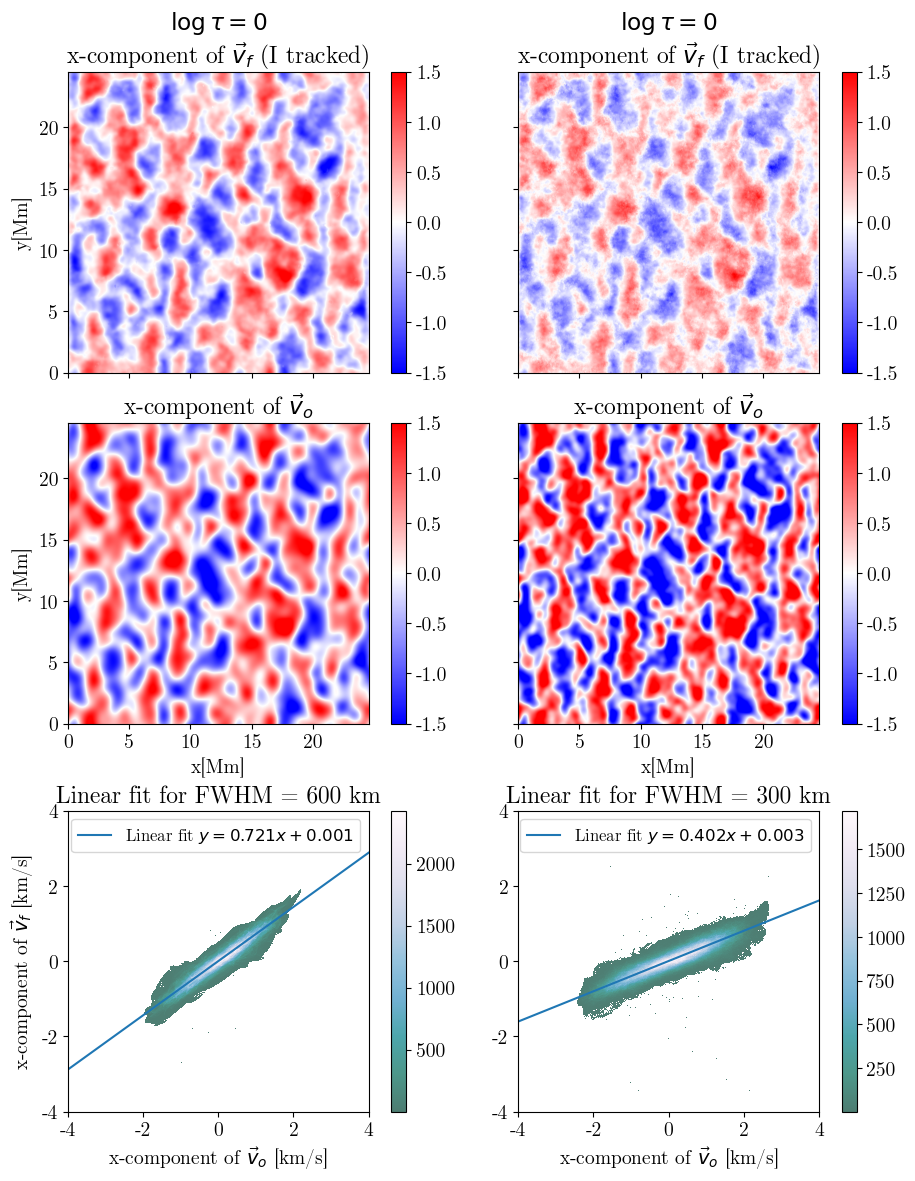

In [18]:
%%time
#fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
fig = plt.figure(constrained_layout=True, figsize = (9,11.7))
#plt.suptitle("Linear fit of FLCT Vx and convolved Vx from simulation for FHWM = {1200, 600, 300, 100}km")
# 4x3 plot, velicina A, velicina B, scatter A i B!!!
#ax1 = plt.subplot2grid((4,3), (0,0))
ax1 = fig.add_subplot(321)
ax1.set_title("$\log\\tau = 0$" + "\n" + "x-component of $\\vec{v}_f$ (I tracked)")
#ax1.set_xlabel("x[Mm]")
ax1.set_xticklabels([])
ax1.set_ylabel("y[Mm]")
im1 = ax1.imshow(Vx_600I_mean[:, :].T, origin='lower', cmap = "bwr", extent = (0, 24.536, 0, 24.536), vmin = -1.5, vmax = 1.5)
plt.colorbar(im1)

#ax2 = plt.subplot2grid((4,3), (0,1))
ax2 = fig.add_subplot(323)
ax2.set_title("x-component of $\\vec{v}_o$")
ax2.set_xlabel("x[Mm]")
ax2.set_ylabel("y[Mm]")
#ax2.set_xticklabels([])
#ax2.set_yticklabels([])
im2 = ax2.imshow(Vx_filtered22[:, :].T, origin='lower', cmap = "bwr", extent = (0, 24.536, 0, 24.536), vmin = -1.5, vmax = 1.5)
plt.colorbar(im2)

#ax3 = plt.subplot2grid((4,3), (0,2))
ax3 = fig.add_subplot(325)
ax3.set_title("Linear fit for FWHM = 600 km")                                
ax3.set_ylabel("x-component of $\\vec{v}_f$ [km/s]")
ax3.set_xlabel("x-component of $\\vec{v}_o$ [km/s]")

data , x_e, y_e = np.histogram2d( Vx_filtered22.flatten(), Vx_600I_mean.flatten(), bins = 30, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([Vx_filtered22.flatten(),Vx_600I_mean.flatten()]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
#x, y, z = x[idx], y[idx], z[idx]

df = pd.DataFrame(dict(x = Vx_filtered22.flatten(), y = Vx_600I_mean.flatten()))
dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        #vmin=np.min(z),
        #vmax=np.max(z),
        alpha = 0.7,
        norm="linear",
        aspect="equal",
        ax=ax3,
        cmap = "PuBuGn_r",
        x_range = (-4,4),
        y_range = (-4,4)
    )

#im3 = ax3.scatter(Vx_filtered22.flatten(), Vx_600I_mean.flatten(), c = 0.73*Vx_600I_mean.flatten(), s = 0.001, alpha = 0.05, cmap = "twilight")
m1I, b1I, *_ = linregress(Vx_filtered22.flatten(), Vx_600I_mean.flatten())
ax3.axline(xy1=(0, b1I), slope=m1I, label=f'Linear fit $y = {m1I:.3f}x {b1I:+.3f}$')
#norm = Normalize(vmin = np.min(z), vmax = np.max(z))
#cbar = plt.colorbar(im3, cm.ScalarMappable(norm = norm),)
#ax3.set_xlim([-4, 4])
#ax3.set_ylim([-4, 4])
plt.colorbar(dsartist)
plt.legend(fontsize = 12)

#ax4 = plt.subplot2grid((4,3), (1,0))
ax4 = fig.add_subplot(322)
ax4.set_title("$\log\\tau = 0$" + "\n" + "x-component of $\\vec{v}_f$ (I tracked)")
#ax4.set_xlabel("x[Mm]")
#ax4.set_ylabel("y[Mm]")
ax4.set_xticklabels([])
ax4.set_yticklabels([])
im4 = ax4.imshow(Vx_300I_mean[:, :].T, origin='lower', cmap = "bwr", extent = (0, 24.536, 0, 24.536), vmin = -1.5, vmax = 1.5)
plt.colorbar(im4)

#ax5 = plt.subplot2grid((4,3), (1,1))
ax5 = fig.add_subplot(324)
ax5.set_title("x-component of $\\vec{v}_o$")
ax5.set_xlabel("x[Mm]")
#ax5.set_ylabel("y[Mm]")
ax5.set_yticklabels([])
im5 = ax5.imshow(Vx_filtered11[:, :].T, origin='lower', cmap = "bwr", extent = (0, 24.536, 0, 24.536), vmin = -1.5, vmax = 1.5)
plt.colorbar(im5)

#ax6 = plt.subplot2grid((4,3), (1,2))
ax6 = fig.add_subplot(326)
ax6.set_title("Linear fit for FWHM = 300 km")                                
#ax6.set_ylabel("FLCT Vx[km/s]")
ax6.set_xlabel("x-component of $\\vec{v}_o$ [km/s]")


df1 = pd.DataFrame(dict(x = Vx_filtered11.flatten(), y = Vx_300I_mean.flatten()))
dsartist1 = dsshow(
        df1,
        ds.Point("x", "y"),
        ds.count(),
        #vmin=np.min(z),
        #vmax=np.max(z),
        alpha = 0.7,
        norm="linear",
        aspect="equal",
        ax=ax6,
        cmap = "PuBuGn_r"
        #cmap = "inferno"
    )

#im6 = ax6.scatter(Vx_filtered11.flatten(), Vx_300I_mean.flatten(), c = 0.45*Vx_filtered11.flatten(), s = 0.001, alpha = 0.3, cmap='PuBuGn')
m2I, b2I, *_ = linregress(Vx_filtered11.flatten(), Vx_300I_mean.flatten())
ax6.axline(xy1=(0, b2I), slope=m2I, label=f'Linear fit $y = {m2I:.3f}x {b2I:+.3f}$')
ax6.set_xlim([-4, 4])
ax6.set_ylim([-4, 4])
plt.colorbar(dsartist1)
plt.legend(fontsize = 12)

#cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
#cbar = fig.colorbar(im, cax=cbar_ax)
#cbar.set_label('$V_x$ [km/s]')


#plt.tight_layout()
plt.savefig("300_600Inte_comp30.png", dpi = 90, bbox_inches = 'tight')

<h2>Correlation</h2>

<h2>600 km</h2>

In [19]:
R_600xInte1 = pearsonr(Vx_600I[0].flatten(), Vx[0].flatten())
print(R_600xInte1)

PearsonRResult(statistic=np.float64(0.5155012600547478), pvalue=np.float64(0.0))


In [20]:
R_600yInte1 = pearsonr(Vy_600I[0].flatten(), Vy[0].flatten())
print(R_600yInte1)

PearsonRResult(statistic=np.float64(0.5033312437851847), pvalue=np.float64(0.0))


In [21]:
R_600xInte2 = pearsonr(Vx_600I_mean.flatten(), Vx_mean_sim90.flatten())
print(R_600xInte2)

PearsonRResult(statistic=np.float64(0.8552779823668517), pvalue=np.float64(0.0))


In [22]:
R_600yInte2 = pearsonr(Vy_600I_mean.flatten(), Vy_mean_sim90.flatten())
print(R_600yInte2)

PearsonRResult(statistic=np.float64(0.8583861492800279), pvalue=np.float64(0.0))


In [23]:
R_600xInte = pearsonr(Vx_600I_mean.flatten(), Vx_filtered22.flatten())
print(R_600xInte)

PearsonRResult(statistic=np.float64(0.9567092493784048), pvalue=np.float64(0.0))


In [24]:
R_600yInte = pearsonr(Vy_600I_mean.flatten(), Vy_filtered22.flatten())
print(R_600xInte)

PearsonRResult(statistic=np.float64(0.9567092493784048), pvalue=np.float64(0.0))


<h2>300 km</h2>

In [25]:
R_300xInte1 = pearsonr(Vx_300I[0].flatten(), Vx[0].flatten())
print(R_300xInte1)

PearsonRResult(statistic=np.float64(0.376106604236294), pvalue=np.float64(0.0))


In [26]:
R_300yInte1 = pearsonr(Vy_300I[0].flatten(), Vy[0].flatten())
print(R_300yInte1)

PearsonRResult(statistic=np.float64(0.3726894362089083), pvalue=np.float64(0.0))


In [27]:
R_300xInte2 = pearsonr(Vx_300I_mean.flatten(), Vx_mean_sim90.flatten())
print(R_300xInte2)

PearsonRResult(statistic=np.float64(0.8567055092456094), pvalue=np.float64(0.0))


In [28]:
R_300yInte2 = pearsonr(Vy_300I_mean.flatten(), Vy_mean_sim90.flatten())
print(R_300yInte2)

PearsonRResult(statistic=np.float64(0.86152848057209), pvalue=np.float64(0.0))


In [29]:
R_300xInte = pearsonr(Vx_300I_mean.flatten(), Vx_filtered11.flatten())
print(R_300xInte)

PearsonRResult(statistic=np.float64(0.9123526038761337), pvalue=np.float64(0.0))


In [30]:
R_300yInte = pearsonr(Vy_300I_mean.flatten(), Vy_filtered11.flatten())
print(R_300xInte)

PearsonRResult(statistic=np.float64(0.9123526038761337), pvalue=np.float64(0.0))


<h2>$B_z$ tracked</h2>

In [31]:
Vx_600B = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_600B = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_tracked.fits")[1].data.transpose(0, 2, 1)

In [32]:
Vx_300B = fits.open("pyFLCT_vx_vy_fwhm_300_dt_10_Bz_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_300B = fits.open("pyFLCT_vx_vy_fwhm_300_dt_10_Bz_tracked.fits")[1].data.transpose(0, 2, 1)

In [33]:
Vx_600B_mean = temporal_avg(Vx_600B, 0, 90)
Vy_600B_mean = temporal_avg(Vy_600B, 0, 90)
Vx_600B_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_tracked.fits")
Vy_600B_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_tracked.fits")

In [34]:
Vx_300B_mean = temporal_avg(Vx_300B, 0, 90)
Vy_300B_mean = temporal_avg(Vy_300B, 0, 90)
Vx_300B_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_tracked.fits")
Vy_300B_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_tracked.fits")

CPU times: user 5.02 s, sys: 686 ms, total: 5.71 s
Wall time: 5.16 s


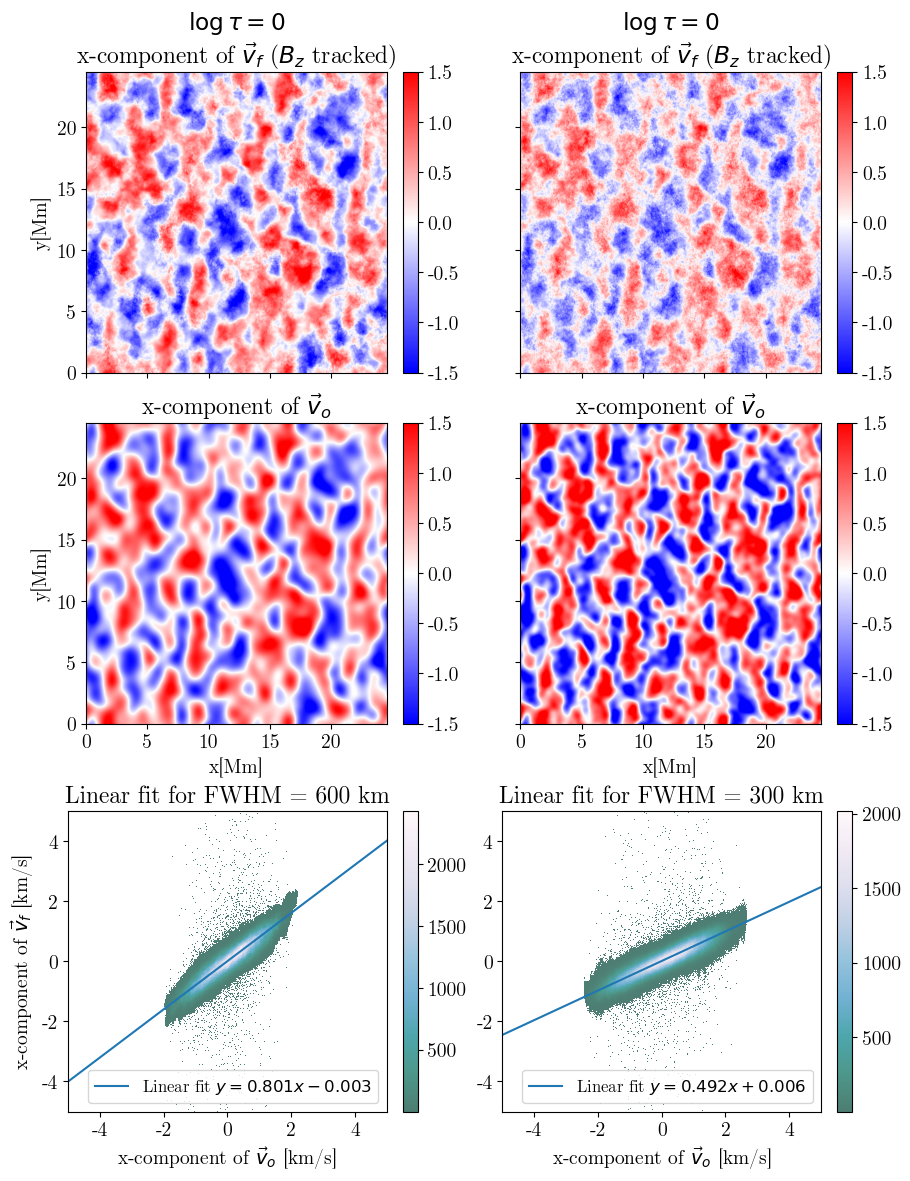

In [35]:
%%time
#fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
f = plt.figure(constrained_layout=True, figsize = (9,11.7))
#plt.suptitle("Linear fit of FLCT Vx and convolved Vx from simulation for FHWM = {1200, 600, 300, 100}km")
# 4x3 plot, velicina A, velicina B, scatter A i B!!!
#ax1 = plt.subplot2grid((4,3), (0,0))
ax1 = f.add_subplot(321)
ax1.set_title("$\log\\tau = 0$" + "\n" + "x-component of $\\vec{v}_f$ ($B_z$ tracked)")
#ax1.set_xlabel("x[Mm]")
ax1.set_xticklabels([])
ax1.set_ylabel("y[Mm]")
im1 = ax1.imshow(Vx_600B_cor[:, :].T, origin='lower', cmap = "bwr", extent = (0, 24.536, 0, 24.536), vmin = -1.5, vmax = 1.5)
plt.colorbar(im1)

#ax2 = plt.subplot2grid((4,3), (0,1))
ax2 = f.add_subplot(323)
ax2.set_title("x-component of $\\vec{v}_o$")
ax2.set_xlabel("x[Mm]")
ax2.set_ylabel("y[Mm]")
#ax2.set_xticklabels([])
#ax2.set_yticklabels([])
im2 = ax2.imshow(Vx_filtered22[:, :].T, origin='lower', cmap = "bwr", extent = (0, 24.536, 0, 24.536), vmin = -1.5, vmax = 1.5)
plt.colorbar(im2)

#ax3 = plt.subplot2grid((4,3), (0,2))
ax3 = f.add_subplot(325)
ax3.set_title("Linear fit for FWHM = 600 km")                                
ax3.set_ylabel("x-component of $\\vec{v}_f$ [km/s]")
ax3.set_xlabel("x-component of $\\vec{v}_o$ [km/s]")

df3 = pd.DataFrame(dict(x = Vx_filtered22.flatten(), y = Vx_600B_cor.flatten()))
dsartist3 = dsshow(
        df3,
        ds.Point("x", "y"),
        ds.count(),
        #vmin=np.min(z),
        #vmax=np.max(z),
        alpha = 0.7,
        norm="linear",
        aspect="auto",
        ax=ax3,
        cmap = "PuBuGn_r",
        #plot_width = 700,
        #plot_height = 700
    )

ax3.set_xlim([-5, 5])
ax3.set_ylim([-5, 5])
#ax3.scatter(Vx_filtered22.flatten(), Vx_600B_cor.flatten(), alpha = 0.05, color="red")
m1B, b1B, *_ = linregress(Vx_filtered22.flatten(), Vx_600B_cor.flatten())
ax3.axline(xy1=(0, b1B), slope=m1B, label=f'Linear fit $y = {m1B:.3f}x {b1B:+.3f}$')
plt.colorbar(dsartist3)
plt.legend(fontsize = 12, loc = "lower right")

#ax4 = plt.subplot2grid((4,3), (1,0))
ax4 = f.add_subplot(322)
ax4.set_title("$\log\\tau = 0$" + "\n" + "x-component of $\\vec{v}_f$ ($B_z$ tracked)")
#ax4.set_xlabel("x[Mm]")
#ax4.set_ylabel("y[Mm]")
ax4.set_xticklabels([])
ax4.set_yticklabels([])
im4 = ax4.imshow(Vx_300B_cor[:, :].T, origin='lower', cmap = "bwr", extent = (0, 24.536, 0, 24.536), vmin = -1.5, vmax = 1.5)
plt.colorbar(im4)

#ax5 = plt.subplot2grid((4,3), (1,1))
ax5 = f.add_subplot(324)
ax5.set_title("x-component of $\\vec{v}_o$")
ax5.set_xlabel("x[Mm]")
#ax5.set_ylabel("y[Mm]")
ax5.set_yticklabels([])
im5 = ax5.imshow(Vx_filtered11[:, :].T, origin='lower', cmap = "bwr", extent = (0, 24.536, 0, 24.536), vmin = -1.5, vmax = 1.5)
plt.colorbar(im5)

#ax6 = plt.subplot2grid((4,3), (1,2))
ax6 = f.add_subplot(326)
ax6.set_title("Linear fit for FWHM = 300 km")                                
#ax6.set_ylabel("FLCT Vx[km/s]")
ax6.set_xlabel("x-component of $\\vec{v}_o$ [km/s]")
ax6.set_xlim([-2, 2])
ax6.set_ylim([-8, 8])
#ax6.scatter(Vx_filtered11.flatten(), Vx_300B_cor.flatten(), s = 2, alpha = 0.05, color="red")

df4 = pd.DataFrame(dict(x = Vx_filtered11.flatten(), y = Vx_300B_cor.flatten()))

dsartist4 = dsshow(
        df4,
        ds.Point("x", "y"),
        ds.count(),
        #vmin=np.min(z),
        #vmax=np.max(z),
        alpha = 0.7,
        norm="linear",
        aspect="auto",
        ax=ax6,
        cmap = "PuBuGn_r",
        #plot_width = 700,
        #plot_height = 700,
        x_range = (-5,5),
        y_range = (-5,5)
    )



m2B, b2B, *_ = linregress(Vx_filtered11.flatten(), Vx_300B_cor.flatten())
ax6.axline(xy1=(0, b2B), slope=m2B, label=f'Linear fit $y = {m2B:.3f}x {b2B:+.3f}$')
plt.colorbar(dsartist4)
plt.legend(fontsize = 12, loc = "lower right")
'''
axins = inset_axes(ax4,
                    width="5%",  
                    height="200%",
                    loc='center right',
                    borderpad=-5
                   )

#cbar_ax = f.add_axes([0.975, 0.15, 0.02, 0.7])
cbar = f.colorbar(im1, cax = axins, location = "top")
cbar.set_label('$V_x$ [km/s]')
'''
#plt.tight_layout()
plt.savefig("300_600Bz_comp30.png", dpi = 90, bbox_inches = 'tight')

<h2>Correlation</h2>

<h2>600 km</h2>

In [36]:
R_600xBz1 = pearsonr(Vx_600B[0].flatten(), Vx[0].flatten())
print(R_600xBz1)

PearsonRResult(statistic=np.float64(0.1736232175028764), pvalue=np.float64(0.0))


In [37]:
R_600yBz1 = pearsonr(Vy_600B[0].flatten(), Vy[0].flatten())
print(R_600yBz1)

PearsonRResult(statistic=np.float64(0.17155251282126913), pvalue=np.float64(0.0))


In [38]:
R_600xBz2 = pearsonr(Vx_600B_mean.flatten(), Vx_mean_sim90.flatten())
print(R_600xBz2)

PearsonRResult(statistic=np.float64(0.5024524488756493), pvalue=np.float64(0.0))


In [39]:
R_600yBz2 = pearsonr(Vy_600B_mean.flatten(), Vy_mean_sim90.flatten())
print(R_600yBz2)

PearsonRResult(statistic=np.float64(0.40460572581840254), pvalue=np.float64(0.0))


In [40]:
R_600xBz = pearsonr(Vx_600B_mean.flatten(), Vx_filtered22.flatten())
print(R_600xBz)

PearsonRResult(statistic=np.float64(0.5557340450351255), pvalue=np.float64(0.0))


In [41]:
R_600yBz = pearsonr(Vy_600B_mean.flatten(), Vy_filtered22.flatten())
print(R_600yBz)

PearsonRResult(statistic=np.float64(0.44749722892128363), pvalue=np.float64(0.0))


<h2 style = "color:blue">Corrected</h2>

In [42]:
R_600xBz2c = pearsonr(Vx_600B_cor.flatten(), Vx_mean_sim90.flatten())
print(R_600xBz2c)
R_600yBz2c = pearsonr(Vy_600B_cor.flatten(), Vy_mean_sim90.flatten())
print(R_600yBz2c)

PearsonRResult(statistic=np.float64(0.8355619529301159), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.8380128718408681), pvalue=np.float64(0.0))


In [43]:
R_600xBzc = pearsonr(Vx_600B_cor.flatten(), Vx_filtered22.flatten())
print(R_600xBzc)
R_600yBzc = pearsonr(Vy_600B_cor.flatten(), Vy_filtered22.flatten())
print(R_600yBzc)

PearsonRResult(statistic=np.float64(0.9229729449919677), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.9261488122400483), pvalue=np.float64(0.0))


<h2>300 km </h2>

In [44]:
R_300xBz1 = pearsonr(Vx_300B[0].flatten(), Vx[0].flatten())
print(R_300xBz1)

PearsonRResult(statistic=np.float64(0.6729079730485092), pvalue=np.float64(0.0))


In [45]:
R_300yBz1 = pearsonr(Vy_300B[0].flatten(), Vy[0].flatten())
print(R_300yBz1)

PearsonRResult(statistic=np.float64(0.6383922448733456), pvalue=np.float64(0.0))


In [46]:
R_300xBz2 = pearsonr(Vx_300B_mean.flatten(), Vx_mean_sim90.flatten())
print(R_300xBz2)

PearsonRResult(statistic=np.float64(0.2553942465349362), pvalue=np.float64(0.0))


In [47]:
R_300yBz2 = pearsonr(Vy_300B_mean.flatten(), Vy_mean_sim90.flatten())
print(R_300yBz2)

PearsonRResult(statistic=np.float64(0.41825424418433155), pvalue=np.float64(0.0))


In [48]:
R_300xBz = pearsonr(Vx_300B_mean.flatten(), Vx_filtered11.flatten())
print(R_300xBz)

PearsonRResult(statistic=np.float64(0.26645654528668766), pvalue=np.float64(0.0))


In [49]:
R_300yBz = pearsonr(Vy_300B_mean.flatten(), Vy_filtered11.flatten())
print(R_300yBz)

PearsonRResult(statistic=np.float64(0.4350107099792823), pvalue=np.float64(0.0))


<h2 style = "color:green">!Corrected!</h2>

In [50]:
R_300xBz2c = pearsonr(Vx_300B_cor.flatten(), Vx_mean_sim90.flatten())
print(R_300xBz2c)
R_300yBz2c = pearsonr(Vy_300B_cor.flatten(), Vy_mean_sim90.flatten())
print(R_300yBz2c)

PearsonRResult(statistic=np.float64(0.8542434644095726), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.8577998353400402), pvalue=np.float64(0.0))


In [51]:
R_300xBzc = pearsonr(Vx_300B_cor.flatten(), Vx_filtered22.flatten())
print(R_300xBzc)
R_300yBzc = pearsonr(Vy_300B_cor.flatten(), Vy_filtered22.flatten())
print(R_300yBzc)

PearsonRResult(statistic=np.float64(0.8935263486662112), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.8982608830205825), pvalue=np.float64(0.0))


<h2 style ="color:orange">CS statistics</h2>

In [52]:
from numpy import dot
from numpy.linalg import norm
def CS_calc(a, b):
    s = 0
    for j in range(len(a)):
        cos_sim = dot(a[j], b[j])/(norm(a[j])*norm(b[j]))
        s = s + cos_sim
    return s/len(a)

In [53]:
csI600 = CS_calc(Vx_filtered22.flatten(), Vx_600I_mean.flatten())
print(csI600)

0.8361790974934896


In [54]:
csI300 = CS_calc(Vx_filtered11.flatten(), Vx_300I_mean.flatten())
print(csI300)

0.7673051622178819


In [55]:
csI600y = CS_calc(Vy_filtered22.flatten(), Vy_600I_mean.flatten())
print(csI600y)

0.8394139607747396


In [56]:
csI300y = CS_calc(Vy_filtered11.flatten(), Vy_300I_mean.flatten())
print(csI300y)

0.7660208808051215


In [57]:
csB600 = CS_calc(Vx_filtered22.flatten(), Vx_600B_cor.flatten())
print(csB600)

0.782806396484375


In [58]:
csB600y = CS_calc(Vy_filtered22.flatten(), Vy_600B_cor.flatten())
print(csB600y)

0.7778396606445312


In [59]:
csB300 = CS_calc(Vx_filtered11.flatten(), Vx_300B_cor.flatten())
print(csB300)

0.7569079928927951


In [60]:
csB300y = CS_calc(Vy_filtered11.flatten(), Vy_300B_cor.flatten())
print(csB300y)

0.7584643893771701
